In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pickle

# Importando grafo
Como antes, vamos abrir um grafo com a elevação já nos nós.

In [2]:
Sanca = pickle.load(open('SCElevation.graph','rb'))

São Carlos:


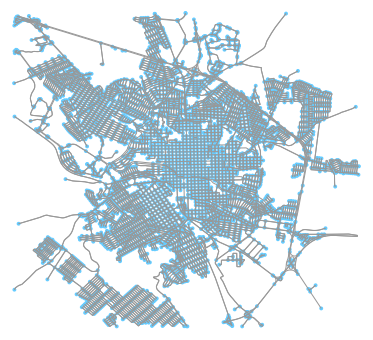

(<Figure size 462.76x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cbb8041748>)

In [3]:
print('São Carlos:')
ox.plot_graph(Sanca)

# Caminho mínimo
Como no notebook do Prof. Boeing, fazer um caminho mínimo é fácil. Vamos usar a distância como impedância:

703692213 1015217729


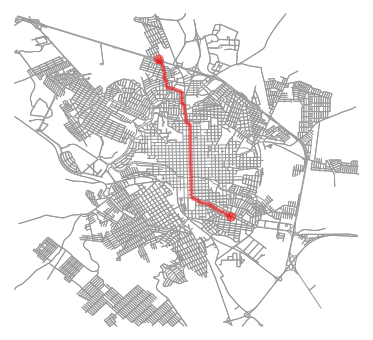

In [4]:
origin, destination = 703692213, 1015217729

route_by_length = nx.shortest_path(Sanca, source=origin, target=destination, weight='length')
print(origin, destination)
fig, ax = ox.plot_graph_route(Sanca, route_by_length, node_size=0)

# Agora vamos criar uma impedância que reflita melhor nosso problema
Essa parte é relativamente fácil, mas possui várias etapas, então qualquer dúvida pode me pedir por email ou ir na sala para resolvermos.

Primeiro adicionamos a inclinação nas arestas:

In [5]:
ox.add_edge_grades(Sanca)

# Adicionando o trabalho necessário em cada trecho
Em primeira análise, vamos considerar que o ser humano é um motor de pode desempenhar uma potência constante. A equação de potência para um ciclista é:
\begin{equation*}
W = C_a \bullet V^3 + [mg(i+C_r)] \bullet V
\end{equation*}

Ca e Cv são as contantes aerodinâmica e de rolamento, vamos adotar 0.3 e 0.003, a massa do ciclista adotaremos como mais ou menos 75kg e a bicicleta mais 15kg resultando um total de 90kg e a gravidade será 9.81

Desse jeito, a potência necessária para um pessoa andar a 40km/h (11,11 m/s) em um trecho plano será:

In [6]:
Ca = 0.3
Cr = 0.003
m = 90 #kg
v = 40/3.6 #m/s
g = 9.81 #m/s²
i = 0 #m/m

W = Ca*v**3 + (m*g*(i+Cr))*v
W

440.9526337448559

Mais ou menos 440 W.

Vamos considerar que essa seja nossa potência base e que o ciclista sempre desempenhará ela. Desse jeito ficamos:
\begin{equation*}
440 = 0.3 \bullet V^3 + [90 \bullet 9.81(i+0.003)] \bullet V
\end{equation*}
O trabalho em um trecho pode ser calculado como:
\begin{equation*}
\tau = W \bullet t
\end{equation*}
Para obter o tempo que o ciclista gasta em um trecho precisaremos da velocidade e para cada inclinação teremos que resolver uma equação de terceiro grau para obtê-la.

Portanto, o primeiro passo é definir uma função para resolver a equação `solve_for_speed`. Nós usaremos a função `roots` do numpy (np) para obter as raíses da equação. como a equação é de terceiro grau, sempre haverá uma raiz real, mas pode haver mais que uma. Não vou entrar em detalhes, mas quando existe mais de uma raiz real a potência será equivalente à maior raiz, se fiz as contas corretamente.

O que vamos fazer então é obter as raíses da equação, filtrar as reais e pegar o maior valor.

In [7]:
def solve_for_speed(i, pot, Ca=0.3, Cr=0.003):
    # polinômio: [Ca]*(s^3) + 0*(s^2) + [90*9.81*(i+Cr)]*(s) - pot = 0
    poly  = [Ca, 0, 90*9.81*(i+Cr), -pot]
    results = np.roots(poly)
    #só consideraremos os resultados na linha dos números reais    
    real_results = []
    for item in results:
        if np.isreal(item):
            real_results.append(float(item))
    #pegamos o maior valor, caso haja mais de uma solução real
    return max(real_results)

# Impedância
Agora vamos aplicar a equação $\tau = W \bullet t$ para os trechos para achar a impedância. Contudo, vamos aplicar algumas restrições:
+ Deve haver uma velocidade mínima. Se o ciclista não é capaz de atingir essa velocidade mesmo exercendo a potencia que o levaria a ter uma velocidade de 40km/h em um trecho plano, consideramos que o trecho é inviável para o ciclista e dizemos que a impedância é infinita (`np.inf`).
+ Deve haver um gasto mínimo de energia. Mesmo em trechos de descida, consideraremos que o ciclista ainda está gastando alguma energia. Essa limitação será imposta de forma que o ciclista deve gatar um número mínimo de Joules por metro de trajeto (vamos considerar 20 J/m  que é mais ou menos 50% do que um ciclista gastaria em um trecho plano).

In [8]:
def impedance(length, i, pot, Ca=0.3, Cr=0.003, speed_floor=10, 
              work_per_meter_floor=20):
    #obs: velocidade entra na função em km/h
    
    #aplicamos a função de antes para achar a velocidade:
    speed = solve_for_speed(i, pot, Ca=Ca, Cr=Cr)
    
    #se velocidade muito baixa, trabalho grande
    if speed*3.6 <= speed_floor:
        work = np.inf
        
    #caso contrário, calculamos o trabalho:
    else:
        time = length/speed
        work = pot*time
        
    #Vamos aplicar a outra restrição. Trabalho por metro deve ser no mínimo `work_per_meter_floor` 
    if work >= work_per_meter_floor*length:
        return work
    else:
        return work_per_meter_floor*length

# Aplicando
Vamos definir uma função para aplicar a impedância em todo o grafo

In [9]:
def get_edge_impedance(G, pot=300, Ca=0.3, Cr=0.003, speed_floor=10, work_per_meter_floor=20):
    for u, v, k, data in G.edges(keys=True, data=True):
        work = impedance(data['length'], data['grade'], pot=pot, Ca=Ca, Cr=Cr, 
                         speed_floor=speed_floor, work_per_meter_floor=work_per_meter_floor)
        data['work'] = work
        data['work per meter'] = work/data['length']

E aplicar ao grafo de São Carlos

In [10]:
get_edge_impedance(Sanca)

C:\Users\nataliarp\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


Vamos dar uma olhada no trabalho necessário para vencer cada metro de via no grafo de São Carlos.

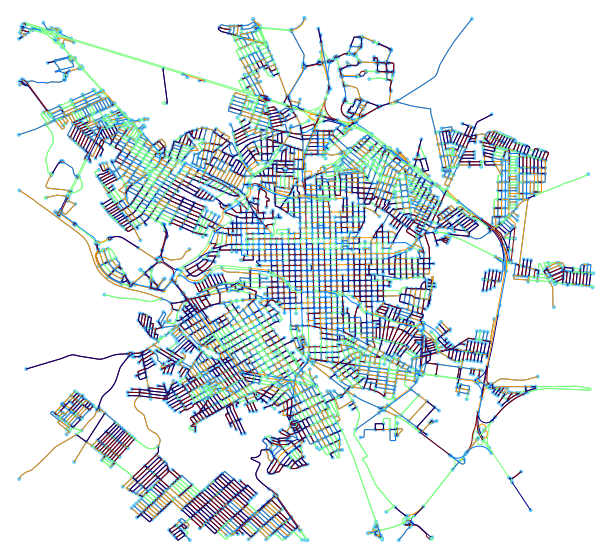

(<Figure size 771.267x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cbb80eb470>)

In [11]:
colors = ox.get_edge_colors_by_attr(Sanca, 'work per meter', cmap='jet_r')
ox.plot_graph(Sanca, edge_color=colors, fig_height=10)

# Caminho mínimo
Agora vamos rodar o mesmo caminho mínimo de antes com o trabalho como impedância e ver se há diferença

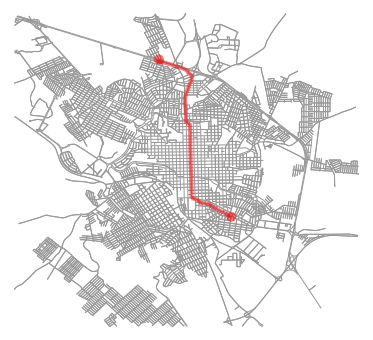

In [12]:
route_by_work = nx.shortest_path(Sanca, source=origin, target=destination, weight='work')
fig, ax = ox.plot_graph_route(Sanca, route_by_work, node_size=0)

Vamos ver a inclinação média do caminho por distância:

In [13]:
grade_len = 0
for i in range(len(route_by_length)-1):
    grade_len += Sanca.edges[(route_by_length[i],route_by_length[i+1],0)]['grade_abs']
avg_grade_len = grade_len/(len(route_by_length)-1)*100
print(f'{avg_grade_len:.02f}%')

3.79%


Vamos ver a inclinação média do caminho por trabalho:

In [14]:
grade_work = 0
for i in range(len(route_by_work)-1):
    grade_work += Sanca.edges[(route_by_work[i],route_by_work[i+1],0)]['grade_abs']
avg_grade_work = grade_work/(len(route_by_work)-1)*100
print(f'{avg_grade_work:.02f}%')

3.39%


In [15]:
print(f'mudança de {(1-avg_grade_len/avg_grade_work)*100:.01f}% na inclinação média')

mudança de -11.8% na inclinação média


O caminho possui uma redução de 11.8% na inclinação média se comparado ao caminho que leva a distância em consideração.